In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader

import argparse
import logging
from tqdm import tqdm
import numpy as np
import pandas as pd
import logging
import os
import math
import copy
import matplotlib.pyplot as plt
import optuna
from datetime import datetime
import random
from sklearn.model_selection import train_test_split

import copy
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer

In [2]:
import sys
sys.path.append('..')

In [3]:
from src.data.data_loader import MIMICDataset,import_data
from src.utils import setup_logger
from src.training.training_nn import *
from src.models.models import ODERNN,GRU
from src.utils import seed_everything

In [4]:
def seed_everything(seed=1234):
    """
    Ensure reproducible results
    
    Args
        seed: random seed (an integer)
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()    

In [5]:
def glc_transform(x):
    x = x.copy()
    x[x > 0] = np.log(x[x > 0]) - np.log(140)
    return x

def glc_invtransform(x):
    x = x.copy()
    x = np.exp(x + np.log(140))
    return x

ginv = glc_invtransform

In [6]:
# seed

DATA_PATH = "../data/analysis.csv"
df = import_data(DATA_PATH)
df.glc = glc_transform(df.glc)
df.glc_1 = glc_transform(df.glc_1)
df['t0'] = df.timer_hr
df['t1'] = df.timer_hr + df.dt
df['glc'] = df.groupby('icustay_id').glc.fillna(method='ffill')
df = df.loc[~df.glc.isnull()]

excluding: 200024
excluding: 200586
excluding: 201104
excluding: 201173
excluding: 201605
excluding: 203383
excluding: 205463
excluding: 205830
excluding: 206288
excluding: 206986
excluding: 208691
excluding: 208937
excluding: 212690
excluding: 212925
excluding: 214617
excluding: 215027
excluding: 215250
excluding: 216192
excluding: 216504
excluding: 216867
excluding: 217645
excluding: 218713
excluding: 218874
excluding: 219153
excluding: 219305
excluding: 220024
excluding: 220671
excluding: 220704
excluding: 221494
excluding: 221514
excluding: 221574
excluding: 221812
excluding: 222096
excluding: 223717
excluding: 224428
excluding: 226283
excluding: 227040
excluding: 227991
excluding: 228262
excluding: 229133
excluding: 229142
excluding: 229929
excluding: 230012
excluding: 230384
excluding: 231775
excluding: 232042
excluding: 232582
excluding: 233553
excluding: 234981
excluding: 235824
excluding: 236999
excluding: 237956
excluding: 238662
excluding: 240029
excluding: 240043
excluding:

AttributeError: 'DataFrame' object has no attribute 'glc_1'

In [ ]:
qt = QuantileTransformer(n_quantiles=10, random_state=0)
df['input'] = qt.fit_transform(df['input'].to_numpy().reshape(-1, 1))
qt = QuantileTransformer(n_quantiles=10, random_state=0)
df['input_hrs'] = qt.fit_transform(df['input_hrs'].to_numpy().reshape(-1, 1))

sample_ids = df.icustay_id.unique()[0:5000]

train_ids, test_ids = train_test_split(sample_ids,test_size=0.25)

df_train = df.loc[df.icustay_id.isin(train_ids)]
df_valid = df.loc[df.icustay_id.isin(test_ids)]


In [ ]:
FEATURE_VARS = ["injection","input_hrs","input","glc"]
TIME_VARS = ["t0","t1"]

class MIMICDataset(Dataset):
    """
    Args:
        patientunitstayids: 
        df:
        ...
    
    Example:
    """
    def __init__(self,df,verbose=True):
        self.X,self.y,self.msk,self.dt = self.load_data(df,verbose=verbose)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx],self.y[idx],self.msk[idx],self.dt[idx]
    
    def load_data(self,df,verbose):
        X_list, y_list, msk_list, dt_list = [], [], [], []
        ids = df.icustay_id.unique()
        if verbose:
            print("reconfiguring data...")
        for id_ in ids:
            df_id = df.loc[df.icustay_id == id_,:]
            if (sum(df_id.msk) == df_id.shape[0]):
                print("excluding:",id_)
                continue
            X = df_id.loc[:,FEATURE_VARS]
            y = df_id.loc[:,"glc_1"]
            msk = df_id.loc[:,"msk"]
            dt = df_id.loc[:,TIME_VARS]
            X = np.array(X).astype(np.float32)
            y = np.array(y).astype(np.float32)
            msk = np.array(msk).astype(np.int32)
            dt = np.array(dt).astype(np.float32)
            X_list.append(X)
            y_list.append(y)
            msk_list.append(msk)
            dt_list.append(dt)
        return X_list,y_list,msk_list,dt_list

In [ ]:
dl_train = DataLoader(MIMICDataset(df_train),batch_size=1)
dl_valid = DataLoader(MIMICDataset(df_valid),batch_size=1)
dataloaders = {'train':dl_train,'validation':dl_valid}

In [10]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
#from torchdiffeq import odeint_adjoint as odeint
from torchdiffeq import odeint

import math

# Base ----------------------------------------------------------------------------

import torch.nn.functional as F

class Baseline(nn.Module):
    def __init__(self, input_dim, hidden_dim, p, output_dim, device):
        super(Baseline, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.p = p
        self.device = device
        
    def train_single_epoch(self,dataloader,optim):
        loss = 0.0
        for i, (x, y, msk, dt) in enumerate(dataloader):
            x = x.to(self.device)
            y = y.view(-1,1).to(self.device)
            dt = dt.to(self.device)
            msk = msk.bool().to(self.device)
            optim.zero_grad()
            preds = self.forward(dt,x)
            loss_step = self.loss_fn(preds,y,~msk.squeeze(0))
            loss_step.backward()
            torch.nn.utils.clip_grad_norm_(self.parameters(), 2.0)
            optim.step()
            loss += loss_step.item()
            if i % 1e3 == 0:
                print("BATCH_loss : {:05.3f}".format(loss_step.item()))
        loss /= (i + 1)
        print("EPOCH_loss : {:05.3f}".format(loss))
        
        return loss
        
    def evaluate(self,dataloader,p=0.0):
        rmse, loss = 0., 0.
        N = 0
        y_preds = []
        y_tests = []
        msks = []
        #dts = []
        with tqdm(total=len(dataloader)) as t:
            for i, (x, y, msk, dt) in enumerate(dataloader):
                N += sum((msk == 0).squeeze(0)).item()
                x = x.to(self.device)
                y = y.view(-1,1).to(self.device)
                dt = dt.to(self.device)
                # model prediction
                y_ = self.forward(dt,x)
                y_preds.append([yc.detach().cpu().numpy() for yc in y_]) 
                y_tests.append(y.cpu().numpy())
                msk = msk.bool().to(self.device)
                rmse += self.get_sse(y_,y,~msk.squeeze(0)).item()
                loss += self.loss_fn(y_,y,~msk.squeeze(0)).item()
                msks.append(msk.cpu().numpy())
                t.update()
        rmse /= N
        loss /= (i + 1)
        rmse = math.sqrt(rmse)
        print("_rmse : {:05.3f}".format(rmse))
        print("_loss : {:05.3f}".format(loss))
        return loss,rmse, y_preds, y_tests, msks

    def get_sse(self,y_,y,msk):
        """
        SSE: sum of squared errors
        """
        if type(y_) == tuple:
            y_ = y_[0]
        c = torch.log(torch.tensor(140.0))
        rmse = torch.sum((torch.exp(y_[msk] + c) - torch.exp(y[msk] + c))**2)
        return rmse

In [11]:
def euler(func,y0,x,t,h):
    if (t[1]-t[0]) == 0:
        return y0
    else :
        tsteps = torch.linspace(t[0],t[1],int(2+(t[1]-t[0]) // h))
        hs = torch.diff(tsteps)
        y = copy.deepcopy(y0)
        for h in hs:
            y += h*func(y,x)
        return y 

In [12]:
class ODEFunc(nn.Module):
    """
    dglucose/dt = NN(glucose,insulin)
    """
    def __init__(self,input_dim):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim+1, 50),
            nn.Tanh(),
            nn.Linear(50, 1),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, y, x):
        yx = torch.cat((y,x),1)
        return self.net(yx)
    
class ODE(Baseline):

    def __init__(self, input_dim, hidden_dim, p, output_dim, device):
        Baseline.__init__(self,input_dim, hidden_dim, p, output_dim, device)
        self.device = device
        self.func = ODEFunc(input_dim).to(device)
        
    def forward(self, dt, x):
        
        x = x.squeeze(0)
        dt = dt.squeeze(0)
        T = x.size(0)
        
        mu_out = torch.zeros(T,1,device = self.device)
        for i in range(0,T):
            y0 = x[i][3].unsqueeze(0).unsqueeze(0)
            x_i = x[i].unsqueeze(0)
            mu_out[i] = euler(self.func,y0,x_i,dt[i],h=1.0)
            
        return mu_out
    
    def loss_fn(self,y_,y,msk):
        return torch.mean((y_[msk] - y[msk])**2)


In [13]:
model = ODE(4, 1, 0.5, 1, "cuda")

In [14]:
t = next(iter(dl_train))[3].squeeze(0).to("cuda")
x = next(iter(dl_train))[0].squeeze(0).to("cuda")
y = next(iter(dl_train))[1].squeeze(0)
msk = next(iter(dl_train))[2].squeeze(0)
y_ = model(t,x)
model(t[:1].unsqueeze(0),x[:1].unsqueeze(0))
# model(t[0],x[0]) # doesn't work but that's okay

tensor([[-0.2451]], device='cuda:0', grad_fn=<CopySlices>)

In [15]:
model_optim = optim.RMSprop(model.parameters(), lr=1e-3)

In [16]:
model.train_single_epoch(dl_train,model_optim)
model.train_single_epoch(dl_train,model_optim)

BATCH_loss : 0.048
BATCH_loss : 0.007
EPOCH_loss : 0.062
BATCH_loss : 0.040
BATCH_loss : 0.008
EPOCH_loss : 0.061


0.06099225716506286

In [17]:
loss,rmse, y_preds, y_tests, msks = model.evaluate(dl_valid)

100%|██████████| 500/500 [00:21<00:00, 22.97it/s]

_rmse : 41.083
_loss : 0.064


In [18]:
rmse

41.08347036697773

In [19]:
df_valid["glc_1_locf"] = df_valid.glc
df_valid.loc[df_valid.glc_1_locf == 0,'glc_1_locf'] = np.NaN
df_valid["glc_1_locf"] = df_valid.groupby('icustay_id')["glc_1_locf"].ffill()
res_rmse_locf = math.sqrt(np.mean((ginv(df_valid.glc_1_locf[df_valid.msk==0]) - ginv(df_valid.glc_1[df_valid.msk==0]))**2))
print("RMSE (locf): {:05.4f}".format(res_rmse_locf))

RMSE (locf): 43.1631


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [20]:
rmse / res_rmse_locf

0.9518190853090943

In [21]:
y_preds = np.concatenate(y_preds)
y_tests = np.concatenate(y_tests)

In [22]:
msks = np.concatenate([msk[0] for msk in msks])

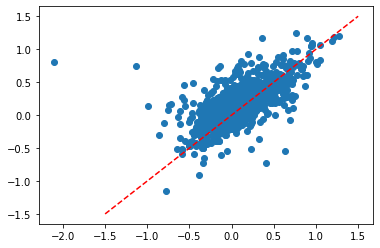

In [23]:
plt.scatter(y_preds[msks],y_tests[msks])
xs = np.linspace(-1.5,1.5)
plt.plot(xs,xs,'--r')

In [24]:
t = next(iter(dl_train))[3].squeeze(0).to("cuda")
x = next(iter(dl_train))[0].squeeze(0).to("cuda")
y = next(iter(dl_train))[1].squeeze(0)
msk = next(iter(dl_train))[2].squeeze(0)
y_ = model(t,x)

In [25]:
# FEATURE_VARS = ["injection","input_hrs","input","glc"]

In [26]:
# xx = torch.tensor([[ 0.0000,  0.4000,  inputs[0], 0.3412],
#         [ 0.0000,  0.0000,  0.0000, 0.2412]], device='cuda:0')
# tt = torch.tensor([[2.0081, 4.0081],
#         [3.0081, 3.4081]], device='cuda:0')

In [27]:
# ginv(xx[:,3].cpu().numpy())

In [28]:
# ys = model(tt,xx)

In [29]:
# ginv(ys.detach().cpu().numpy())

In [30]:
# FEATURE_VARS = ["injection","input_hrs","input","glc"]

In [120]:
print(ginv(np.array(0.3)))
xx = torch.tensor([[0.0000,  0.0,  0.0, 0.3],
        [ 0.0000,  0.0000,  0.0000, 0.2412]], device='cuda:0')
tt = torch.tensor([[0.0081, 3.0081],
        [3.0081, 3.4081]], device='cuda:0')
ginv(model(tt,xx).detach().cpu().numpy())

188.98023306064033


array([[163.73433],
       [174.47978]], dtype=float32)

In [ ]:
# time gap = 3 hours
#input = 0 -> 163
#input = 0.9 -> 154
#input = 0.9 & injection = 1 -> 163
#input_hrs = 0 -> 163
#input_hrs = 0.8 -> 129

In [124]:
max_in = 200
inputs = np.linspace(0.,1.0,max_in,dtype=np.float32)

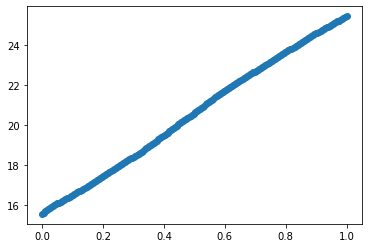

In [141]:
change = np.zeros(max_in)
for i in range(max_in):
    xx = torch.tensor([[0.0000,  0.0000,  inputs[i], 0.2],
            [ 0.0000,  0.0000,  0.0000, 0.2412]], device='cuda:0')
    tt = torch.tensor([[0.0081, 3.0081],
            [3.0081, 3.4081]], device='cuda:0')
    ys = model(tt,xx)
    change[i] = ginv(xx[:,3].cpu().numpy())[0]-ginv(ys.detach().cpu().numpy())[0].item()
plt.scatter(inputs,change)

In [66]:
max_in = 200
inputs = np.linspace(0,1.0,max_in,dtype=np.float32)

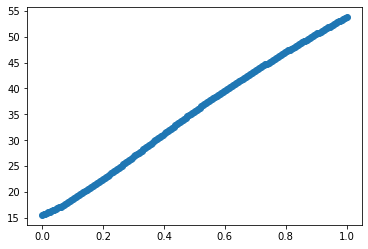

In [67]:
change = np.zeros(max_in)
for i in range(max_in):
    xx = torch.tensor([[0.0000,  inputs[i],  0.0, 0.2],
            [ 0.0000,  0.0000,  0.0000, 0.2412]], device='cuda:0')
    tt = torch.tensor([[0.0081, 3.0081],
            [3.0081, 3.4081]], device='cuda:0')
    ys = model(tt,xx)
    change[i] = ginv(xx[:,3].cpu().numpy())[0]-ginv(ys.detach().cpu().numpy())[0].item()
plt.scatter(inputs,change)

(array([   9.,   60.,  197.,  788., 1262.,  913.,  484.,  199.,   74.,
          24.]),
 array([-0.81450804, -0.60476563, -0.39502323, -0.18528082,  0.02446158,
         0.23420398,  0.44394639,  0.65368879,  0.8634312 ,  1.0731736 ,
         1.28291601]),
 <BarContainer object of 10 artists>)

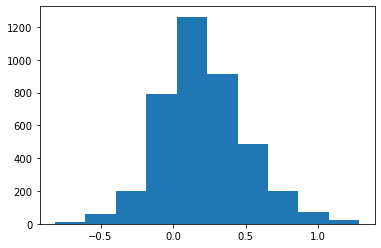

In [36]:
plt.hist(df_valid.loc[df_valid.input > 0.0,['glc']])

In [37]:
np.mean(df_valid.loc[df_valid.input > 0.0,['glc']])

glc    0.208368
dtype: float64

In [59]:
np.mean(df_valid.loc[df_valid.input > 0.0,['glc_1']])

glc_1    0.139029
dtype: float64

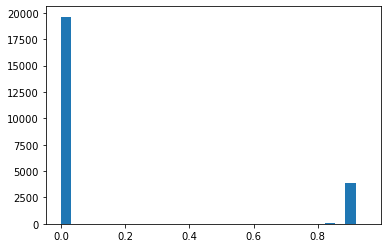

In [126]:
plt.hist(df_valid.loc[df_valid.input > -1000.0,['input']],30)
plt.show()

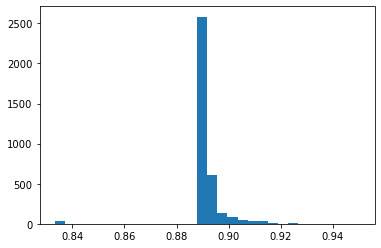

In [129]:
plt.hist(df_valid.loc[(df_valid.input > -1000.0) & (df_valid.injection == 1),['input']],30)
plt.show()

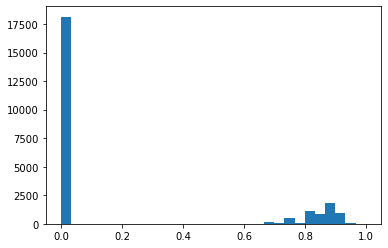

In [127]:
plt.hist(df_valid.loc[df_valid.input_hrs > -1000.0,['input_hrs']],30)
plt.show()

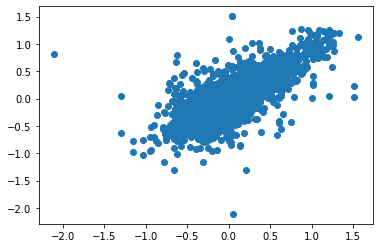

In [39]:
plt.scatter(df_valid.loc[df_valid.input_hrs > 0.0,['glc']].to_numpy().reshape(-1),
            df_valid.loc[df_valid.input_hrs > 0.0,['glc_1']].to_numpy().reshape(-1))

In [40]:
from sklearn.linear_model import LinearRegression

In [76]:
x1 = df_valid.loc[(df_valid.input > 0.0) & (df_valid.msk == 0),['glc']].to_numpy()
y1 = df_valid.loc[(df_valid.input > 0.0) & (df_valid.msk == 0),['glc_1']].to_numpy()

In [77]:
reg = LinearRegression().fit(x1,y1)

In [78]:
reg.coef_

array([[0.61753677]])

In [79]:
reg.intercept_

array([-0.01587074])

In [136]:
df_train.loc[(df_train.injection > 0) & (df_train.msk == 0)]

,icustay_id,timer_hr,injection,input_hrs,input,glc,dt,glc_1,msk,t0,t1
135,253656,18.691389,1,0.844222,0.906367,-0.241162,0.116667,-0.028988,0,18.691389,18.808056
138,253656,19.874722,1,0.844222,0.891386,-0.028988,2.750000,0.336472,0,19.874722,22.624722
140,253656,22.708056,1,0.000000,0.893883,0.336472,3.983333,0.517943,0,22.708056,26.691389
142,253656,26.841389,1,0.000000,0.896380,0.517943,4.850000,0.649345,0,26.841389,31.691389
164,253656,50.658056,1,0.000000,0.893883,0.256855,1.033333,0.509396,0,50.658056,51.691389
...,...,...,...,...,...,...,...,...,...,...,...
91594,206276,9.566944,1,0.000000,0.890137,0.424334,3.100000,-0.028988,0,9.566944,12.666944
91599,206276,22.033611,1,0.000000,0.888889,0.082238,4.783333,0.055570,0,22.033611,26.816944
91602,206276,33.316944,1,0.000000,0.888889,0.095310,3.666667,-0.154151,0,33.316944,36.983611
91609,206276,57.566944,1,0.000000,0.888889,0.139762,3.733333,-0.145852,0,57.566944,61.300278
